## Deer Are Cool, Let's Protect Them
Amanda West (acw9gs), Ben Cosgro, Sean Grace

**Helpful Links:**
- https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
- https://medium.com/riga-data-science-club/geographic-coordinate-encoding-with-tensorflow-feature-columns-e750ae338b7c
- https://melvincabatuan.github.io/Keras-Tutorial-Deep-Learning-in-Python-Walkthrough/


**Random Thoughts:**
- What if we bootstrapped to make additional positive CWD cases to train the neural network?

In [204]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SimpleRNN
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.optimizers import RMSprop
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

# read in the data
deer = pd.read_csv("DMA1_withlatlong.csv")

In [154]:
deer.head(2)

,Sample Date,Sex,Age,Status,Lat_Cent,Long_Cent,Active - Hunter Killed,Active - Other,Active - Road-Killed,Targeted - Other,Targeted-Clinical suspect
0,2009-01-03,1.0,1.5,0.0,39.060983,-78.471737,1,0,0,0,0
1,2009-01-03,0.0,0.5,0.0,39.060983,-78.471737,1,0,0,0,0


In [155]:
### 3 loss functions
#status
#lat
#long
#potentially convert year/month to sequential numbers

In [156]:
# reshuffle so Status is first (for x-y split a few lines down)
deer = deer[['Status', 'Sample Date', 'Age', 'Sex', 'Lat_Cent', 'Long_Cent',
             'Active - Hunter Killed', 'Active - Other', 'Active - Road-Killed',
             'Targeted - Other', 'Targeted-Clinical suspect']]
deer['Sample Date'] = pd.to_datetime(deer['Sample Date'])
deer['Age'] = pd.to_numeric(deer['Age'],errors='coerce')

<AxesSubplot:>

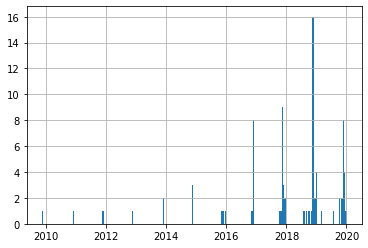

In [157]:
deer[deer['Status']==1]['Sample Date'].hist(bins=240)

In [158]:
# features
X = deer.iloc[:,1:]  

# without timestamp 
#X = deer.iloc[:,2:]  

# response
y = deer.Status

In [159]:
X["Sample Date"] = (X["Sample Date"]-X["Sample Date"].min()).astype('timedelta64[Y]').astype(int)+1
X

,Sample Date,Age,Sex,Lat_Cent,Long_Cent,Active - Hunter Killed,Active - Other,Active - Road-Killed,Targeted - Other,Targeted-Clinical suspect
0,1,1.5,1.0,39.060983,-78.471737,1,0,0,0,0
1,1,0.5,0.0,39.060983,-78.471737,1,0,0,0,0
2,1,2.5,0.0,39.132197,-78.413342,1,0,0,0,0
3,1,2.5,0.0,39.004224,-78.529508,1,0,0,0,0
4,1,2.5,1.0,39.074248,-78.415461,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
9775,12,3.5,0.0,39.156444,-78.207609,0,0,1,0,0
9776,12,1.5,1.0,39.202525,-78.317590,0,0,1,0,0
9777,12,2.5,1.0,39.053248,-78.137302,0,0,1,0,0
9778,12,2.5,1.0,39.260037,-78.296748,0,0,1,0,0


In [160]:
X['Sample Date'].value_counts().head(50)

10    1537
7     1508
9     1463
8     1372
11    1135
6      650
3      609
2      517
5      393
4      312
1      231
12      53
Name: Sample Date, dtype: int64

<AxesSubplot:>

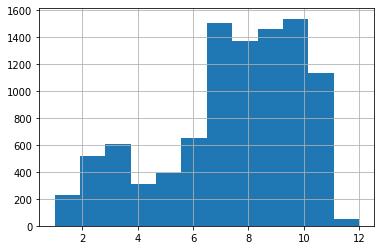

In [161]:
X['Sample Date'].hist(bins=12)

In [162]:
y=pd.DataFrame(y)
y

,Status
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
9775,0.0
9776,0.0
9777,0.0
9778,0.0


In [163]:
X.head(2)
#X.apply(lambda x: x.astype(np.float64), axis=1)

,Sample Date,Age,Sex,Lat_Cent,Long_Cent,Active - Hunter Killed,Active - Other,Active - Road-Killed,Targeted - Other,Targeted-Clinical suspect
0,1,1.5,1.0,39.060983,-78.471737,1,0,0,0,0
1,1,0.5,0.0,39.060983,-78.471737,1,0,0,0,0


In [164]:
# split training data by outcome (get even class split for training data)
#X_train1 = X[y['Status']==1]
#y_train1 = y[y['Status']==1]
#X_train0 = X[y['Status']==0]
#y_train0 = y[y['Status']==0] 
#X_train0['Status'] = list(y_train0.Status)
#X_train0, _, y_train0, _ = train_test_split(X_train0, X_train0[['Status']], test_size=((X_train0.shape[0])/(X.shape[0])), random_state=2, shuffle = False)
#X_train0['Status'] = list(y_train0.Status)
#X_train1['Status'] = list(y_train1.Status)
#X_train_all = pd.concat([X_train0, X_train1])
#X_train, y_train = X_train_all.iloc[:,:-1], X_train_all[['Status']]

In [202]:
# split train & test, x & y up
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
train, test = train_test_split(deer, test_size=0.2, shuffle=False)

In [205]:
train = TimeseriesGenerator(train, train, length=1, sampling_rate=1, stride=1, batch_size = 5)
test = TimeseriesGenerator(test, test, length=1, sampling_rate=1, stride=1, batch_size = 5)

In [166]:
from sklearn.utils import class_weight
y_train=y_train.values.reshape(7824,)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weights = {i : class_weights[i] for i in range(2)}
class_weights

{0: 0.5032805866460826, 1: 76.70588235294117}

In [167]:
# it doesn't like strings/objects like age and date, so we need to 
# recast these into variables that tensorflow can take as a next step
# we can also reclassify lat/long to a single crossed feature column to see
# if that improves anything (like at the top)
X_train.info()
X_train.shape
#y_train.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7824 entries, 0 to 7823
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Sample Date                7824 non-null   int64  
 1   Age                        7541 non-null   float64
 2   Sex                        7824 non-null   float64
 3   Lat_Cent                   7774 non-null   float64
 4   Long_Cent                  7774 non-null   float64
 5   Active - Hunter Killed     7824 non-null   int64  
 6   Active - Other             7824 non-null   int64  
 7   Active - Road-Killed       7824 non-null   int64  
 8   Targeted - Other           7824 non-null   int64  
 9   Targeted-Clinical suspect  7824 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 672.4 KB


(7824, 10)

In [191]:
# Simple neural net that DOES work (have to take out time stamp variable though, i.e. above)
# Uncomment to use

model = Sequential()
model.add(Flatten(input_shape=[10,]))
model.add(keras.layers.BatchNormalization())
model.add(Dense(150, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [69]:
# More complex neural net (still a work in progress)
# Uncomment to use
model = Sequential()
model.add(TimeDistributed(Conv2D(filters=6, 
                                 kernel_size=3,
                                 strides=1,
                                 activation='relu'), 
                                 batch_input_shape=(1, )+X_train.shape))
model.add(TimeDistributed(MaxPooling2D(pool_size=2)))
#model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, stateful=True, return_sequences=True))
model.add(LSTM(10, stateful=True))
model.add(Dense(24))
model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape', 'acc'])

ValueError: Input 0 of layer conv2d_1 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (135, 9)

In [213]:
simple_rnn = Sequential()
simple_rnn.add(SimpleRNN(4, input_shape=(1, 1)))
simple_rnn.add(Dense(1))
simple_rnn.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='../model/simple_rnn_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)

In [214]:
simple_rnn_history = simple_rnn.fit_generator(train
                                              , epochs=100
                                              , validation_data=test
                                              , verbose=1)

KeyError: 1

In [ ]:
plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

In [216]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(1, 1), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

checkpointer = ModelCheckpoint(filepath='../model/stacked_lstm_weights.hdf5'
                               , verbose=0
                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=10
                             , verbose=0)
#with open("../model/stacked_lstm.json", "w") as m:
 #   m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit_generator(train
                                                  , epochs=100
                                                  , validation_data=test
                                                  , verbose=0
                                                  , callbacks=[checkpointer, earlystopper])
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

KeyError: 1

In [190]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[1, 135, 10])
])


model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_test, y_test))

ValueError: Input 0 of layer simple_rnn_38 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 1, 135, 10)

In [192]:
# note: X_train shape and input_shape must have matching # cols
print(X_train.shape)    
print(model.input_shape) 
print(model.output_shape)

(7824, 10)
(None, 10)
(None, 1)


In [193]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])    

In [194]:
history = model.fit(X_train, 
                    y_train,
                    epochs=50, 
                    batch_size=10,
                    class_weight=class_weights,
                    validation_data=(X_test, y_test), 
                    verbose=1)

Epoch 1/50
783/783 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.9941 - val_loss: nan - val_accuracy: 0.9826
Epoch 2/50
783/783 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.9935 - val_loss: nan - val_accuracy: 0.9826
Epoch 3/50
783/783 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.9914 - val_loss: nan - val_accuracy: 0.9826
Epoch 4/50
783/783 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.9929 - val_loss: nan - val_accuracy: 0.9826
Epoch 5/50
783/783 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.9937 - val_loss: nan - val_accuracy: 0.9826
Epoch 6/50
783/783 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.9949 - val_loss: nan - val_accuracy: 0.9826
Epoch 7/50
783/783 [==============================] - 1s 1ms/step - loss: nan - accuracy: 0.9946 - val_loss: nan - val_accuracy: 0.9826
Epoch 8/50
783/783 [============================

In [188]:
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 10)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10)                40        
_________________________________________________________________
dense_33 (Dense)             (None, 150)               1650      
_________________________________________________________________
dense_34 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_35 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_36 (Dense)             (None, 15)                765       
_________________________________________________________________
dense_37 (Dense)             (None, 1)               

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


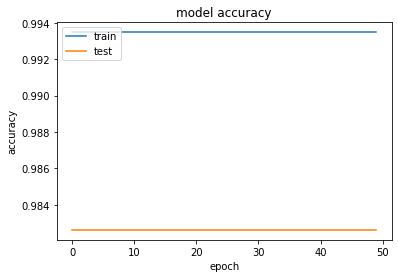

In [178]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [179]:
score = model.evaluate(X_test, y_test,verbose=1)

62/62 [==============================] - 0s 767us/step - loss: nan - accuracy: 0.9826


In [181]:
# oh no, it's so accurate because it's predicting every single point as 0!
# that isn't helpful for us, we need some values to be classified at 1 sometimes....
preds = model.predict(X_test)
#preds = np.where(preds > 0.0001, 1, 0)
print(preds)

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]
